# Variational Autoencoder for STL Objects

The goal of this notebook is to produce a Variational Autoencoder (VAE) that can encode and then decode Voxel objects.

This VAE is based off of the implementation demonstrated in [this YouTube video](https://www.youtube.com/watch?v=LtpU1yBStlU) [github link](https://github.com/ajbrock/Generative-and-Discriminative-Voxel-Modeling/blob/master/Generative/VAE.py). We refer to this VAE as the "Example VAE" in this notebook.

Another good example: https://github.com/hiranumn/DLmodels/blob/master/voxel_modeling/3D-Conv-VAE%20implementation%20(ModelNet%20Chair%20example).ipynb

## Notes

* We still use Thingi10k as our data source. Thingi10k's objects are stl files, so we employ methods explored in stl_voxelization.ipynb to convert each stl file to binvox (a voxel format).
* The Example VAE is written in python with theano and lasagne
* Lasagne's Glorot Uniform initializer \[[docs](https://lasagne.readthedocs.io/en/latest/modules/init.html)\] is the same as Xavier Uniform initializer (Tensorflow's API [docs](https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer)).
* The encoder uses conv3d layers and the decoder uses conv3d_transpose layers; TF describes [here] (https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose) that conv3d_transpose is the opposite of conv3d.

## Env Setup

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import matplotlib.pyplot as plt
%matplotlib inline

# autoreload modules
%load_ext autoreload
%autoreload 2

# set seeds for reproducibility
np.random.seed(12)
tf.set_random_seed(12)

## Data Import

In [2]:
# import data
import env
from data.thingi10k import Thingi10k
from data.stl import save_vectors_as_stl, plot_mesh
from data.voxels import plot_voxels
from models import MODEL_DIR


thingi = Thingi10k.init10k(pctile=.8)
# apply filter
thingi.filter_by_tag('animal')
#thingi = Thingi10k.init10()
#thingi = Thingi10k.init10(pctile=.1)
n_samples = len(thingi)
n_samples

123

In [3]:
class VariationalAutoencoder():
    
    def __init__(self, input_dim, latent_dim, learning_rate, keep_prob, verbose=False, 
                 kl_div_loss_weight=5, recon_loss_weight=5e-4, ckpt_dir='voxel_vae'):
        """
        Args:
            kl_div_loss_weight: float, weight for KL Divergence loss when computing total loss
            recon_loss_weight: float, weight for reconstruction loss when computing total loss

        """
        # network and training params
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.verbose = verbose
        self.kl_div_loss_weight = kl_div_loss_weight
        self.recon_loss_weight = recon_loss_weight
        
        self._input_x = tf.placeholder(tf.float32, shape=(None, self.input_dim, self.input_dim, self.input_dim, 1))
        self._keep_prob = tf.placeholder(dtype=tf.float32)
        self._trainable = tf.placeholder(dtype=tf.bool)

        self.encoder, self.decoder, self.loss, self.optimizer = self._init_graph(self._input_x, self._keep_prob, self._trainable)
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()
        
        # Setup Model Saving
        self.ckpt_dir = os.path.join(MODEL_DIR, ckpt_dir)
        self.saver = tf.train.Saver()
        self.recons = list()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    def _print_shape(self, tensor, name=None):
        if self.verbose:
            if not name:
                name = tensor.name
            print('{}:'.format(name), tensor.shape)
        return
    
    def _make_encoder(self, input_x, keep_prob, trainable):
        
        # tf conv3d: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d
        # tf glorot init: https://www.tensorflow.org/api_docs/python/tf/glorot_uniform_initializer
        conv1 = tf.layers.conv3d(input_x,
                                 filters=8,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 #activation=tf.nn.elu,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv1')
        self._print_shape(conv1)
        # the Example VAE specifies the activation functions as part of the layer
        # we specify the activation function as a seperate tensor
        # it is unknown if this is the preferred method in Tensorflow, but we know
        # it works from work in the 3D-VAE-GAN notebook
        # we also take advantage of batch_normalization
        # more info here:
        # https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85
        # with the hope that it gives speed without sacrificing quality
        # tf batch norm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        # tf elu (exponential linear unit): https://www.tensorflow.org/api_docs/python/tf/nn/elu
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='enc_lrelu1')
        self._print_shape(lrelu1)

        conv2 = tf.layers.conv3d(lrelu1,
                                 filters=16,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv2')
        self._print_shape(conv2)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='enc_lrelu2')
        self._print_shape(lrelu2)

        conv3 = tf.layers.conv3d(lrelu2,
                                 filters=32,
                                 kernel_size=[3, 3, 3],
                                 strides=(1, 1, 1),
                                 padding='valid',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv3')
        self._print_shape(conv3)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='enc_lrelu3')
        self._print_shape(lrelu3)
        
        conv4 = tf.layers.conv3d(lrelu2,
                                 filters=64,
                                 kernel_size=[3, 3, 3],
                                 strides=(2, 2, 2),
                                 padding='same',
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_conv4')
        self._print_shape(conv4)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='enc_lrelu4')
        self._print_shape(lrelu4)
        
        # Apply one fully-connected layer after Conv3d layers
        # tf dense layer: https://www.tensorflow.org/api_docs/python/tf/layers/dense
        dense1 = tf.layers.dense(lrelu4,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='enc_dense1')
        self._print_shape(dense1)
        network_output = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable), name='enc_lrelu5')
        self._print_shape(network_output)
        
        # apply dropout to prevent overtraining
        # why do we flatten?
        enc_output = tf.layers.flatten(tf.nn.dropout(network_output, keep_prob), name='enc_output')
        self._print_shape(enc_output)
        
        # transform the network output into the latent vector
        z_mu = tf.layers.dense(enc_output,
                         units=self.latent_dim,
                         # Example VAE does not use an initializer here
                         #kernel_initializer=tf.initializers.glorot_uniform(),
                         name='enc_mu')
        self._print_shape(z_mu)

        # Example VAE uses a custom layer to extract sigma
        # Here we borrow sigma calc from 3D-VAE-GAN
        z_sig = 0.5 * tf.layers.dense(enc_output, units=self.latent_dim, name='enc_sig')
        self._print_shape(z_sig, 'enc_sig')
        
        # epsilon is a random draw from the latent space
        epsilon = tf.random_normal(tf.stack([tf.shape(enc_output)[0], self.latent_dim]))
        self._print_shape(epsilon, 'epsilon')
        z = z_mu + tf.multiply(epsilon, tf.exp(z_sig))
        self._print_shape(z, 'z')
        
        return z, z_mu, z_sig
    
    def _make_decoder(self, input_z, trainable):
        
        # There is some magic in the Example VAE that adds conditional input based on the
        # class of the image. We do not have that luxury as we are attempting to do this
        # with input that lacks classes.
        # TODO: if poor results, try classes
        self._print_shape(input_z, 'input_z')

        # Why conv3d_transpose instead of conv3d?
        #
        # from https://www.tensorflow.org/api_docs/python/tf/nn/conv3d_transpose,
        #     "This operation is sometimes called "deconvolution" after Deconvolutional Networks,
        #      but is actually the transpose (gradient) of conv3d rather than an actual deconvolution."
        #
        # conv3d_transpose: https://www.tensorflow.org/api_docs/python/tf/layers/conv3d_transpose
        dense1 = tf.layers.dense(input_z,
                                 units=343,
                                 kernel_initializer=tf.initializers.glorot_uniform(),
                                 name='dec_dense1')
        self._print_shape(dense1)
        lrelu1 = tf.nn.elu(tf.layers.batch_normalization(dense1, training=trainable))
        self._print_shape(lrelu1)

        #z = tf.reshape(z, (-1, 1, 1, 1, n_latent))
        reshape_z = tf.reshape(lrelu1, shape=(-1, 7, 7, 7, 1), name='reshape_z')
        self._print_shape(reshape_z)
        #print('reshape_z: ', reshape_z.shape)
        #for value in reshape_z.shape:
        #    print(type(value))

        conv1 = tf.layers.conv3d_transpose(reshape_z,
                                           filters=64,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           padding='same',
                                           # Example VAE does not mention bias
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv1')
        self._print_shape(conv1)
        lrelu2 = tf.nn.elu(tf.layers.batch_normalization(conv1, training=trainable), name='dec_lrelu2')
        self._print_shape(lrelu2)

        conv2 = tf.layers.conv3d_transpose(lrelu2,
                                           filters=32,
                                           kernel_size=[3, 3, 3],
                                           # Example VAE used .5 stride values, but Tensorflow complains
                                           # of being forced to use a float value here
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv2')
        self._print_shape(conv2)
        lrelu3 = tf.nn.elu(tf.layers.batch_normalization(conv2, training=trainable), name='dec_lrelu3')
        self._print_shape(lrelu3)

        conv3 = tf.layers.conv3d_transpose(lrelu3,
                                           filters=16,
                                           kernel_size=[3, 3, 3],
                                           strides=(1, 1, 1),
                                           # changed to valid to hit correct dimension
                                           padding='valid',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv3')
        self._print_shape(conv3)
        lrelu4 = tf.nn.elu(tf.layers.batch_normalization(conv3, training=trainable), name='dec_lrelu4')
        self._print_shape(lrelu4)

        conv4 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=8,
                                           kernel_size=[4, 4, 4],
                                           #strides=(1.0 / 2, 1.0 / 2, 1.0 / 2),
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv4')
        self._print_shape(conv4)
        lrelu5 = tf.nn.elu(tf.layers.batch_normalization(conv4, training=trainable), name='dec_lrelu5')
        self._print_shape(lrelu5)

        conv5 = tf.layers.conv3d_transpose(lrelu4,
                                           filters=1,
                                           kernel_size=[3, 3, 3],
                                          # changed to 2 to hit correct dimension
                                           strides=(2, 2, 2),
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer=tf.initializers.glorot_uniform(),
                                           name='dec_conv5')
        self._print_shape(conv5)
        #decoded_output = tf.nn.tanh(conv5)
        decoded_output = tf.nn.sigmoid(conv5)
        #decoded_output = conv5
        self._print_shape(decoded_output)
        
        return decoded_output
    
    def _make_loss(self, enc_input, dec_output, z_mu, z_sig):
        """
        Info on loss in VAE:
          * https://stats.stackexchange.com/questions/332179/how-to-weight-kld-loss-vs-reconstruction-loss-in-variational-auto-encoder
          
        Args:
            enc_input: tensor, input tensor into VAE
            dec_output: tensor, decoded output tensor from VAE

        Return:
            float, 
        """
        self._print_shape(dec_output, 'loss_dec_output')
        arg1 = tf.reshape(dec_output, (-1, self.input_dim ** 3))
        self._print_shape(arg1, 'loss_dec')
        arg2 = tf.reshape(self._input_x, (-1, self.input_dim ** 3))
        self._print_shape(arg2, 'loss_enc')
        reconstruction_loss = tf.reduce_sum(tf.squared_difference(arg1, arg2), 1)

        KL_divergence = -0.5 * tf.reduce_sum(1.0 + 2.0 * z_sig - z_mu ** 2 - tf.exp(2.0 * z_sig), 1)

        mean_KL = tf.reduce_sum(KL_divergence)
        mean_recon = tf.reduce_sum(reconstruction_loss)

        # tf reduce_mean: https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean
        loss = tf.reduce_mean(self.kl_div_loss_weight * KL_divergence + self.recon_loss_weight * reconstruction_loss)
        
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss)

        return loss, optimizer

    def _init_graph(self, input_x, keep_prob, trainable):
        encoder, enc_mu, enc_sig = self._make_encoder(input_x, keep_prob, trainable)
        decoder = self._make_decoder(encoder, trainable)
        loss, optimizer = self._make_loss(encoder, decoder, enc_mu, enc_sig)
        return encoder, decoder, loss, optimizer
        
    def train(self, generator, epochs=10, display_step=1, save_step=1):
        
        start = time.time()
        for epoch_num, epoch in enumerate(range(epochs)):

            for batch_num, batch in enumerate(generator()):
                
                print('Epoch: {}, Batch: {}'.format(epoch_num, batch_num))
                # repeat for extra practice on each shape
                for _ in range(20):

                    _, loss = self.sess.run(
                        (self.optimizer, self.loss),
                        feed_dict={self._input_x: batch, self._keep_prob:self.keep_prob, self._trainable: True}
                    )
                
            if (epoch + 1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), 
                      "Loss =", "{:.9f}".format(loss),
                      "Elapsed time: {} mins".format((time.time() - start) / 60))
                print('Generation Example:')
                
                # prepare for generation
                #print(batch[0][0])
                self._print_shape(batch[0], 'Example shape (before reshape)')
                recon_input = np.reshape(batch[0], (1, self.input_dim, self.input_dim, self.input_dim, 1))
                self._print_shape(recon_input, 'Example shape')
                
                # generate!
                recon = self.reconstruct(recon_input)
                self._print_shape(recon, 'Recon')

                # prepare for plotting
                recon_input = np.reshape(recon_input, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon_input, 'Example shape (for plotting)')
                recon = np.reshape(recon, (self.input_dim, self.input_dim, self.input_dim))
                self._print_shape(recon, 'Recon (for plotting)')
                # network outputs decimals; here we force them to True/False for plotting
                recon = recon > 0.5
                # replace all nans with zeros
                #recon = np.nan_to_num(recon)
                
                # save the generated object in case we wish to review later
                path = os.path.join(self.ckpt_dir, 'recon_epoch-{}.npy'.format(epoch))
                self.recons.append(recon)

                # visualize
                self.visualize_reconstruction(recon_input, recon)

            if (epoch + 1) % save_step == 0:
                # Save the variables to disk.
                save_path = self.saver.save(self.sess, os.path.join(self.ckpt_dir, "model_epoch-{}.ckpt".format(epoch)))
                print("Model saved in path: {}".format(save_path))
                                       
        return

    def restore(self, model_ckpt):
        self.saver.restore(self.sess, model_ckpt)
        return
    
    def close(self):
        self.sess.close()
        return
            
    def reconstruct(self, input_x):
        """
        Use VAE to reconstruct given data
        """
        decoded = self.sess.run(self.decoder, 
            feed_dict={self._input_x: input_x, self._keep_prob: 1.0, self._trainable: False})
        return decoded
    
    def visualize_reconstruction(self, original_x, reconstructed_x, name=None):
        title = '' if not name else ': {}'.format(name)
        plot_voxels(original_x, title='Original' + title)
        plot_voxels(reconstructed_x, title='Autoencoded' + title)
        return

    def __repr__(self):
        return '<VariationalAutoencoder(input_dim={}, latent_dim={}, learning_rate={}, keep_prob={})>'.format(
            self.input_dim, self.latent_dim, self.learning_rate, self.keep_prob)


Epoch: 0, Batch: 0
Epoch: 0, Batch: 1
Epoch: 0, Batch: 2
Epoch: 0, Batch: 3
Epoch: 1, Batch: 0
Epoch: 1, Batch: 1
Epoch: 1, Batch: 2
Epoch: 1, Batch: 3
Epoch: 2, Batch: 0
Epoch: 2, Batch: 1
Epoch: 2, Batch: 2
Epoch: 2, Batch: 3
Epoch: 3, Batch: 0
Epoch: 3, Batch: 1
Epoch: 3, Batch: 2
Epoch: 3, Batch: 3
Epoch: 4, Batch: 0
Epoch: 4, Batch: 1
Epoch: 4, Batch: 2
Epoch: 4, Batch: 3
Epoch: 0005 Loss = 6467.603027344 Elapsed time: 4.217125988006591 mins
Generation Example:


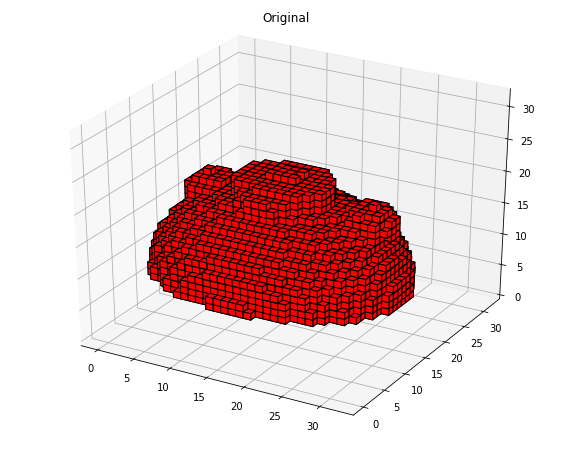

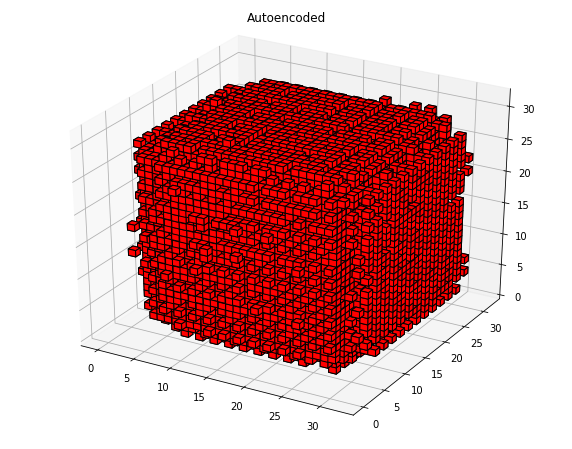

Epoch: 5, Batch: 0
Epoch: 5, Batch: 1
Epoch: 5, Batch: 2
Epoch: 5, Batch: 3
Epoch: 6, Batch: 0
Epoch: 6, Batch: 1
Epoch: 6, Batch: 2
Epoch: 6, Batch: 3
Epoch: 7, Batch: 0
Epoch: 7, Batch: 1
Epoch: 7, Batch: 2
Epoch: 7, Batch: 3
Epoch: 8, Batch: 0
Epoch: 8, Batch: 1
Epoch: 8, Batch: 2
Epoch: 8, Batch: 3
Epoch: 9, Batch: 0
Epoch: 9, Batch: 1
Epoch: 9, Batch: 2
Epoch: 9, Batch: 3
Epoch: 0010 Loss = 5079.115234375 Elapsed time: 8.576570574442545 mins
Generation Example:


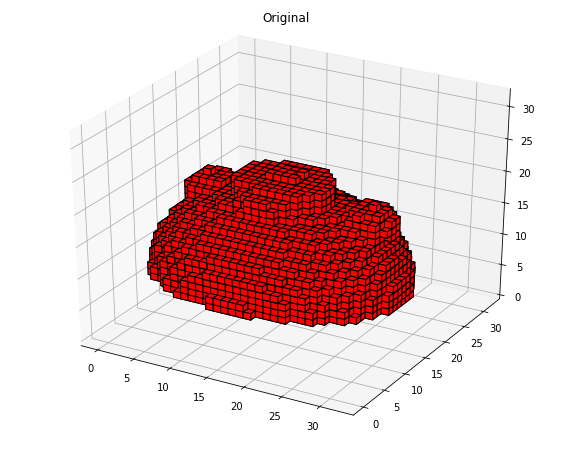

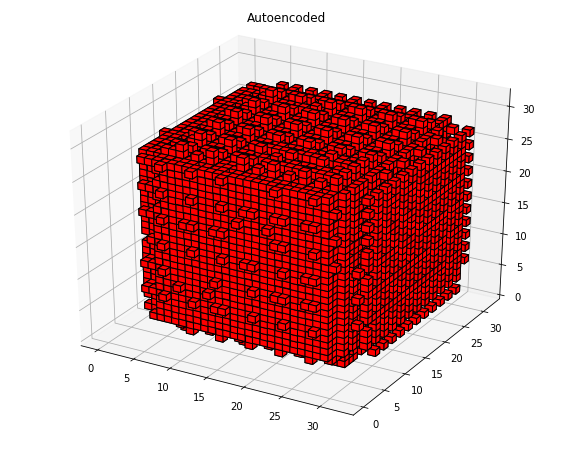

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-9.ckpt
Epoch: 10, Batch: 0
Epoch: 10, Batch: 1
Epoch: 10, Batch: 2
Epoch: 10, Batch: 3
Epoch: 11, Batch: 0
Epoch: 11, Batch: 1
Epoch: 11, Batch: 2
Epoch: 11, Batch: 3
Epoch: 12, Batch: 0
Epoch: 12, Batch: 1
Epoch: 12, Batch: 2
Epoch: 12, Batch: 3
Epoch: 13, Batch: 0
Epoch: 13, Batch: 1
Epoch: 13, Batch: 2
Epoch: 13, Batch: 3
Epoch: 14, Batch: 0
Epoch: 14, Batch: 1
Epoch: 14, Batch: 2
Epoch: 14, Batch: 3
Epoch: 0015 Loss = 4019.511962891 Elapsed time: 13.001642107963562 mins
Generation Example:


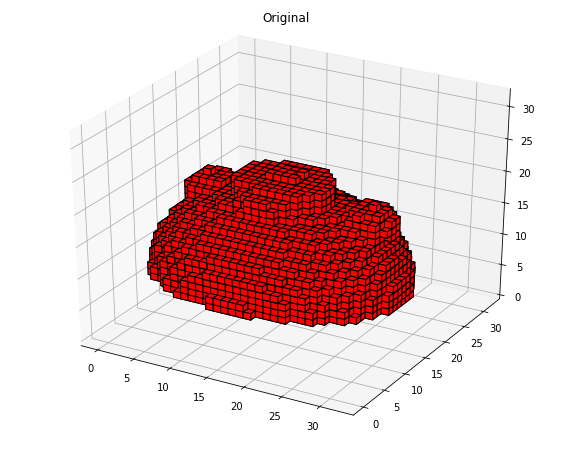

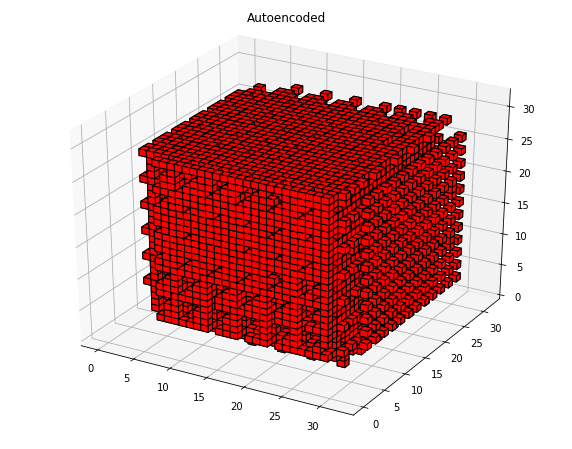

Epoch: 15, Batch: 0
Epoch: 15, Batch: 1
Epoch: 15, Batch: 2
Epoch: 15, Batch: 3
Epoch: 16, Batch: 0
Epoch: 16, Batch: 1
Epoch: 16, Batch: 2
Epoch: 16, Batch: 3
Epoch: 17, Batch: 0
Epoch: 17, Batch: 1
Epoch: 17, Batch: 2
Epoch: 17, Batch: 3
Epoch: 18, Batch: 0
Epoch: 18, Batch: 1
Epoch: 18, Batch: 2
Epoch: 18, Batch: 3
Epoch: 19, Batch: 0
Epoch: 19, Batch: 1
Epoch: 19, Batch: 2
Epoch: 19, Batch: 3
Epoch: 0020 Loss = 3790.633789062 Elapsed time: 17.436680622895558 mins
Generation Example:


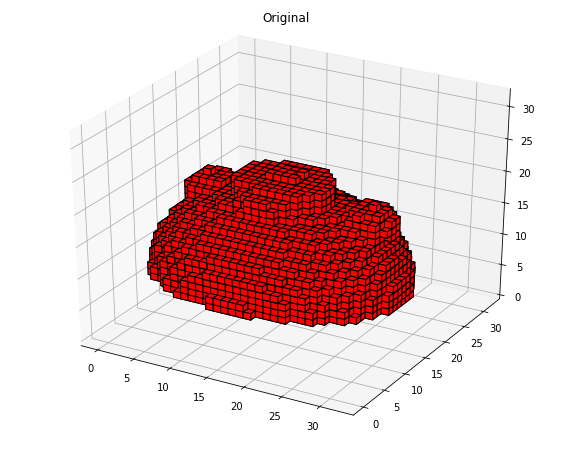

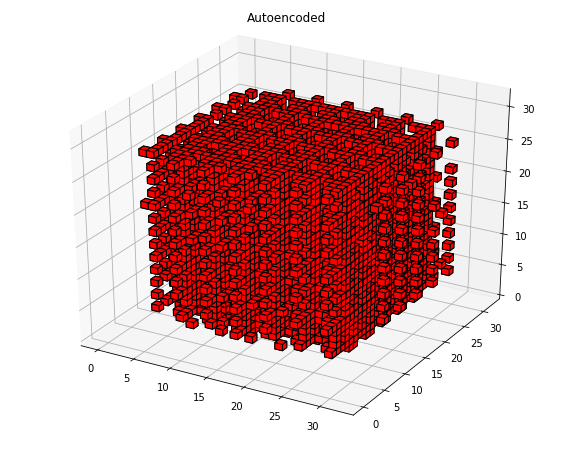

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-19.ckpt
Epoch: 20, Batch: 0
Epoch: 20, Batch: 1
Epoch: 20, Batch: 2
Epoch: 20, Batch: 3
Epoch: 21, Batch: 0
Epoch: 21, Batch: 1
Epoch: 21, Batch: 2
Epoch: 21, Batch: 3
Epoch: 22, Batch: 0
Epoch: 22, Batch: 1
Epoch: 22, Batch: 2
Epoch: 22, Batch: 3
Epoch: 23, Batch: 0
Epoch: 23, Batch: 1
Epoch: 23, Batch: 2
Epoch: 23, Batch: 3
Epoch: 24, Batch: 0
Epoch: 24, Batch: 1
Epoch: 24, Batch: 2
Epoch: 24, Batch: 3
Epoch: 0025 Loss = 5077.687500000 Elapsed time: 21.81706397930781 mins
Generation Example:


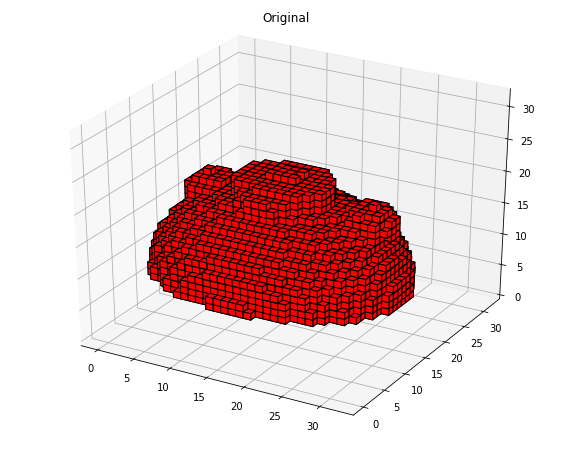

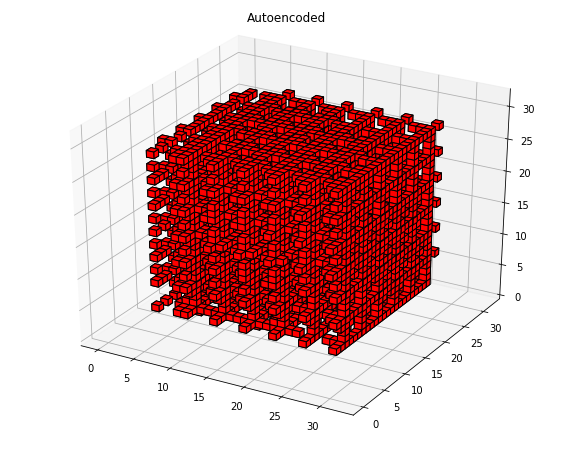

Epoch: 25, Batch: 0
Epoch: 25, Batch: 1
Epoch: 25, Batch: 2
Epoch: 25, Batch: 3
Epoch: 26, Batch: 0
Epoch: 26, Batch: 1
Epoch: 26, Batch: 2
Epoch: 26, Batch: 3
Epoch: 27, Batch: 0
Epoch: 27, Batch: 1
Epoch: 27, Batch: 2
Epoch: 27, Batch: 3
Epoch: 28, Batch: 0
Epoch: 28, Batch: 1
Epoch: 28, Batch: 2
Epoch: 28, Batch: 3
Epoch: 29, Batch: 0
Epoch: 29, Batch: 1
Epoch: 29, Batch: 2
Epoch: 29, Batch: 3
Epoch: 0030 Loss = 3879.578369141 Elapsed time: 26.163510704040526 mins
Generation Example:


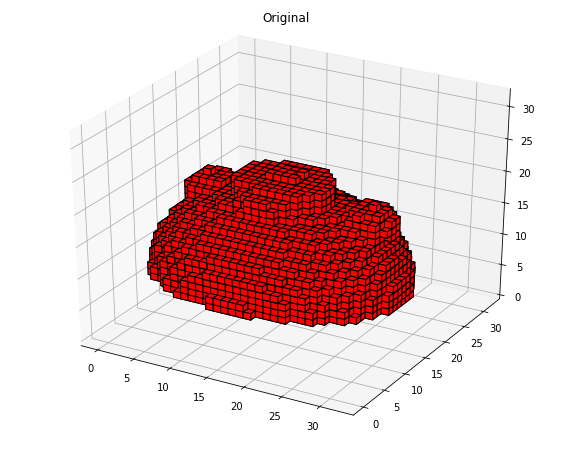

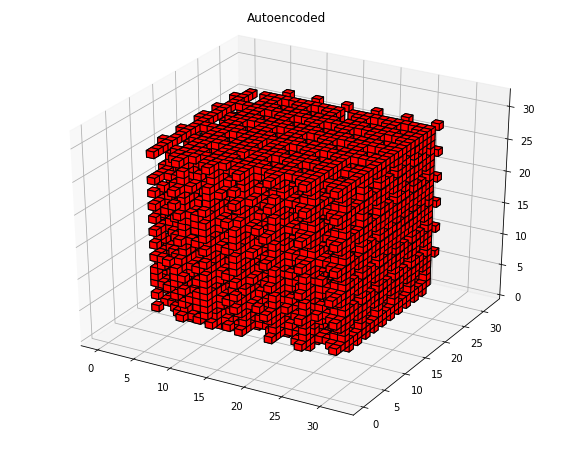

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-29.ckpt
Epoch: 30, Batch: 0
Epoch: 30, Batch: 1
Epoch: 30, Batch: 2
Epoch: 30, Batch: 3
Epoch: 31, Batch: 0
Epoch: 31, Batch: 1
Epoch: 31, Batch: 2
Epoch: 31, Batch: 3
Epoch: 32, Batch: 0
Epoch: 32, Batch: 1
Epoch: 32, Batch: 2
Epoch: 32, Batch: 3
Epoch: 33, Batch: 0
Epoch: 33, Batch: 1
Epoch: 33, Batch: 2
Epoch: 33, Batch: 3
Epoch: 34, Batch: 0
Epoch: 34, Batch: 1
Epoch: 34, Batch: 2
Epoch: 34, Batch: 3
Epoch: 0035 Loss = 5473.902832031 Elapsed time: 30.544266458352407 mins
Generation Example:


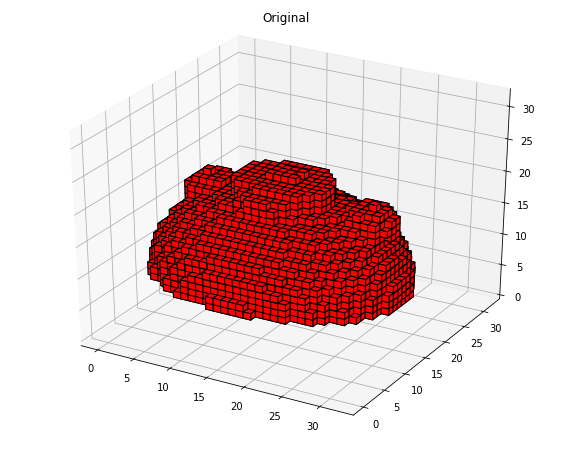

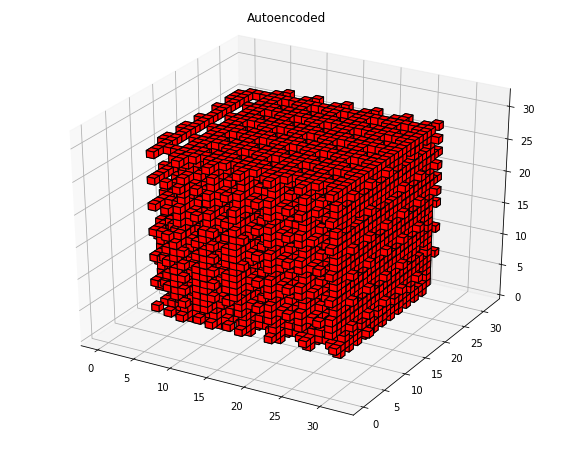

Epoch: 35, Batch: 0
Epoch: 35, Batch: 1
Epoch: 35, Batch: 2
Epoch: 35, Batch: 3
Epoch: 36, Batch: 0
Epoch: 36, Batch: 1
Epoch: 36, Batch: 2
Epoch: 36, Batch: 3
Epoch: 37, Batch: 0
Epoch: 37, Batch: 1
Epoch: 37, Batch: 2
Epoch: 37, Batch: 3
Epoch: 38, Batch: 0
Epoch: 38, Batch: 1
Epoch: 38, Batch: 2
Epoch: 38, Batch: 3
Epoch: 39, Batch: 0
Epoch: 39, Batch: 1
Epoch: 39, Batch: 2
Epoch: 39, Batch: 3
Epoch: 0040 Loss = 6275.727539062 Elapsed time: 34.951262358824415 mins
Generation Example:


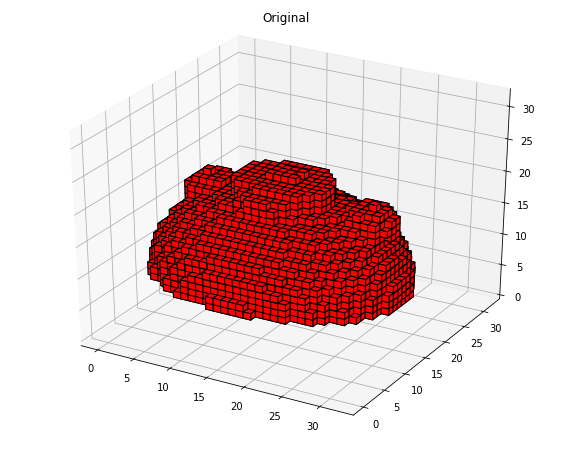

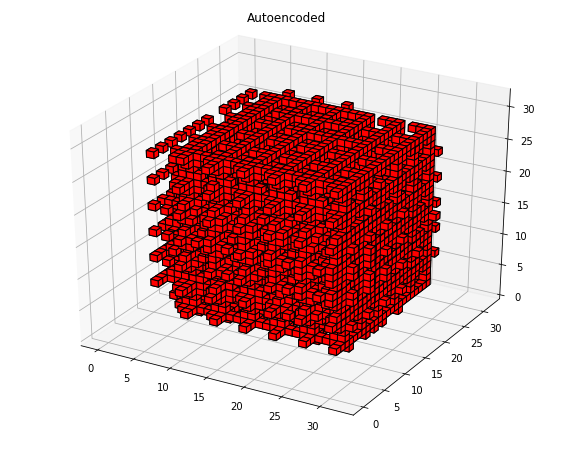

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-39.ckpt
Epoch: 40, Batch: 0
Epoch: 40, Batch: 1
Epoch: 40, Batch: 2
Epoch: 40, Batch: 3
Epoch: 41, Batch: 0
Epoch: 41, Batch: 1
Epoch: 41, Batch: 2
Epoch: 41, Batch: 3
Epoch: 42, Batch: 0
Epoch: 42, Batch: 1
Epoch: 42, Batch: 2
Epoch: 42, Batch: 3
Epoch: 43, Batch: 0
Epoch: 43, Batch: 1
Epoch: 43, Batch: 2
Epoch: 43, Batch: 3
Epoch: 44, Batch: 0
Epoch: 44, Batch: 1
Epoch: 44, Batch: 2
Epoch: 44, Batch: 3
Epoch: 0045 Loss = 7180.345703125 Elapsed time: 39.329125893116 mins
Generation Example:


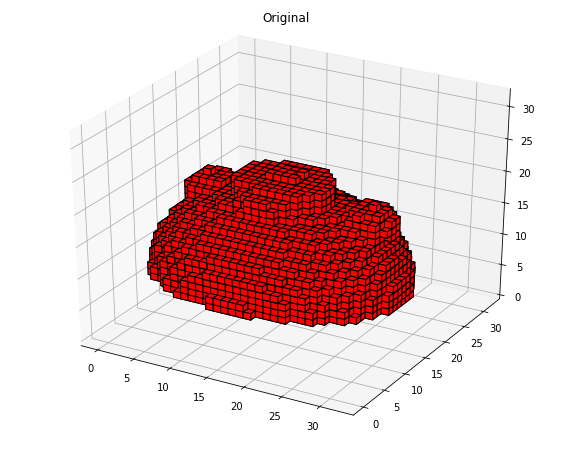

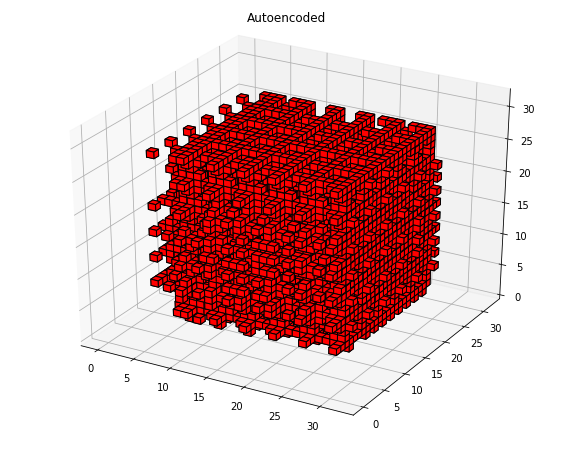

Epoch: 45, Batch: 0
Epoch: 45, Batch: 1
Epoch: 45, Batch: 2
Epoch: 45, Batch: 3
Epoch: 46, Batch: 0
Epoch: 46, Batch: 1
Epoch: 46, Batch: 2
Epoch: 46, Batch: 3
Epoch: 47, Batch: 0
Epoch: 47, Batch: 1
Epoch: 47, Batch: 2
Epoch: 47, Batch: 3
Epoch: 48, Batch: 0
Epoch: 48, Batch: 1
Epoch: 48, Batch: 2
Epoch: 48, Batch: 3
Epoch: 49, Batch: 0
Epoch: 49, Batch: 1
Epoch: 49, Batch: 2
Epoch: 49, Batch: 3
Epoch: 0050 Loss = 9257.333007812 Elapsed time: 43.69930607477824 mins
Generation Example:


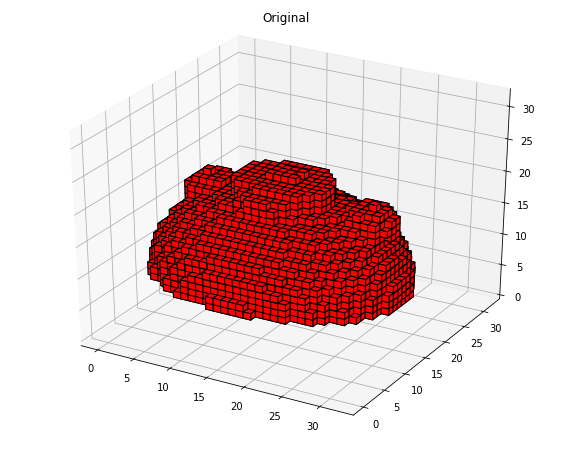

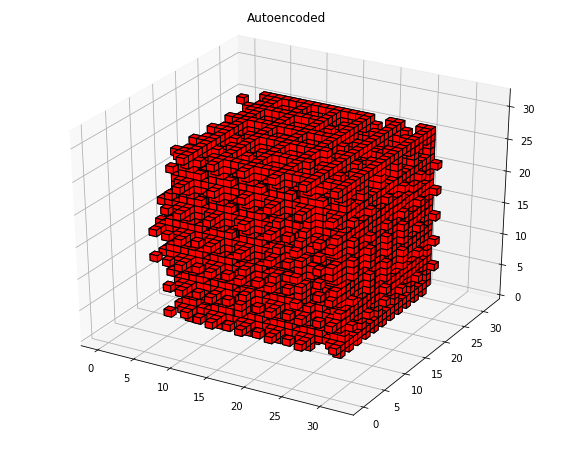

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-49.ckpt
Epoch: 50, Batch: 0
Epoch: 50, Batch: 1
Epoch: 50, Batch: 2
Epoch: 50, Batch: 3
Epoch: 51, Batch: 0
Epoch: 51, Batch: 1
Epoch: 51, Batch: 2
Epoch: 51, Batch: 3
Epoch: 52, Batch: 0
Epoch: 52, Batch: 1
Epoch: 52, Batch: 2
Epoch: 52, Batch: 3
Epoch: 53, Batch: 0
Epoch: 53, Batch: 1
Epoch: 53, Batch: 2
Epoch: 53, Batch: 3
Epoch: 54, Batch: 0
Epoch: 54, Batch: 1
Epoch: 54, Batch: 2
Epoch: 54, Batch: 3
Epoch: 0055 Loss = 12277.412109375 Elapsed time: 48.075100274880725 mins
Generation Example:


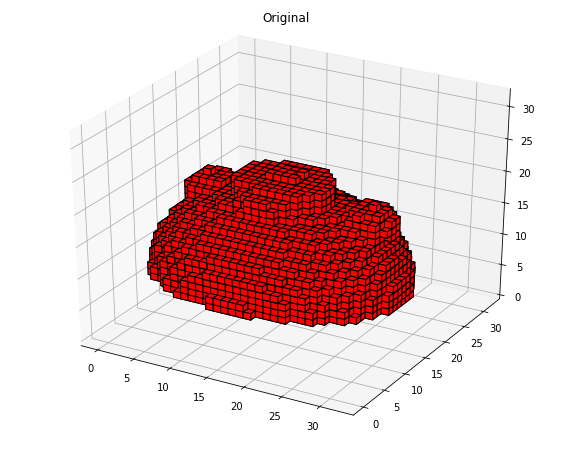

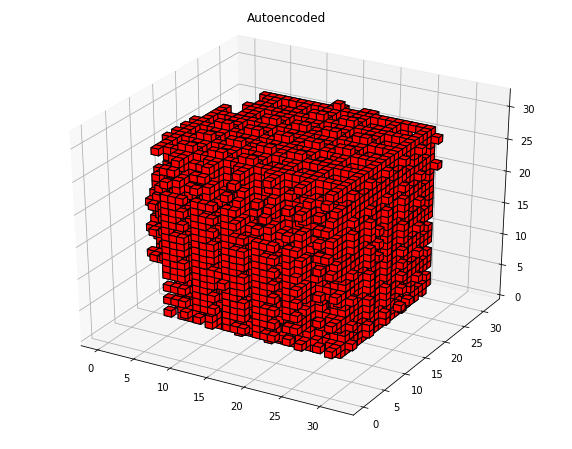

Epoch: 55, Batch: 0
Epoch: 55, Batch: 1
Epoch: 55, Batch: 2
Epoch: 55, Batch: 3
Epoch: 56, Batch: 0
Epoch: 56, Batch: 1
Epoch: 56, Batch: 2
Epoch: 56, Batch: 3
Epoch: 57, Batch: 0
Epoch: 57, Batch: 1
Epoch: 57, Batch: 2
Epoch: 57, Batch: 3
Epoch: 58, Batch: 0
Epoch: 58, Batch: 1
Epoch: 58, Batch: 2
Epoch: 58, Batch: 3
Epoch: 59, Batch: 0
Epoch: 59, Batch: 1
Epoch: 59, Batch: 2
Epoch: 59, Batch: 3
Epoch: 0060 Loss = 10810.776367188 Elapsed time: 52.46376516819 mins
Generation Example:


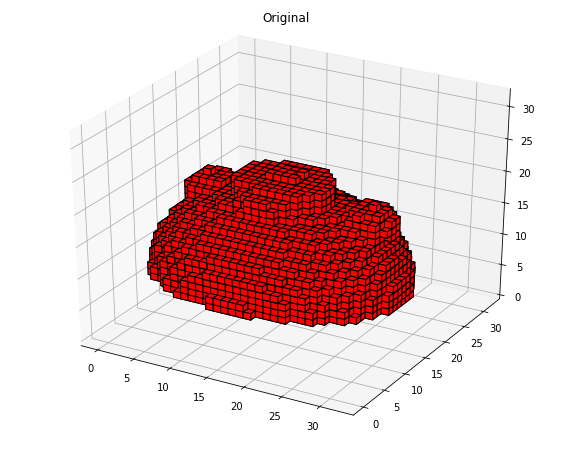

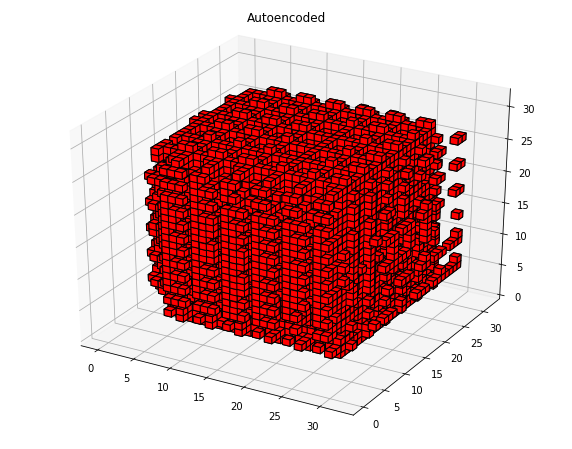

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-59.ckpt
Epoch: 60, Batch: 0
Epoch: 60, Batch: 1
Epoch: 60, Batch: 2
Epoch: 60, Batch: 3
Epoch: 61, Batch: 0
Epoch: 61, Batch: 1
Epoch: 61, Batch: 2
Epoch: 61, Batch: 3
Epoch: 62, Batch: 0
Epoch: 62, Batch: 1
Epoch: 62, Batch: 2
Epoch: 62, Batch: 3
Epoch: 63, Batch: 0
Epoch: 63, Batch: 1
Epoch: 63, Batch: 2
Epoch: 63, Batch: 3
Epoch: 64, Batch: 0
Epoch: 64, Batch: 1
Epoch: 64, Batch: 2
Epoch: 64, Batch: 3
Epoch: 0065 Loss = 9665.772460938 Elapsed time: 56.89905285835266 mins
Generation Example:


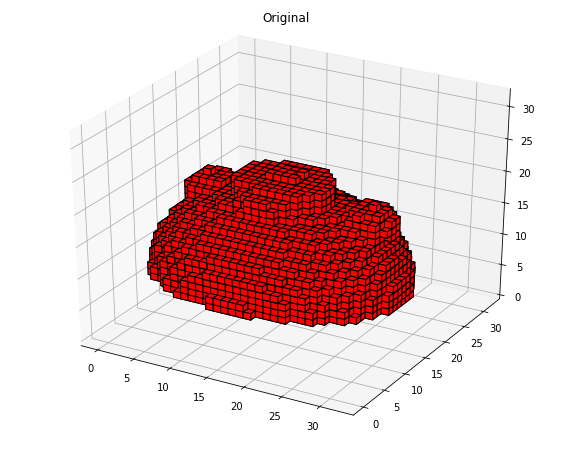

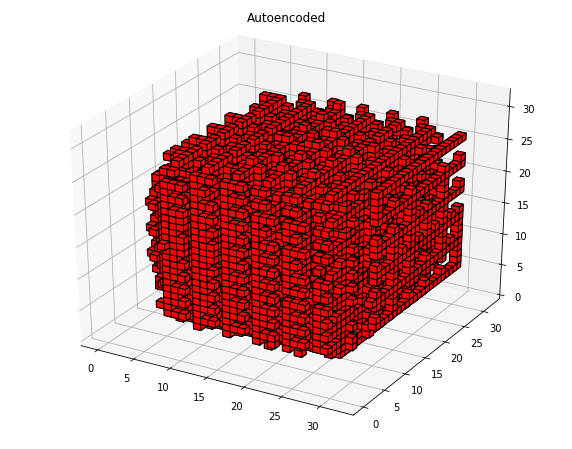

Epoch: 65, Batch: 0
Epoch: 65, Batch: 1
Epoch: 65, Batch: 2
Epoch: 65, Batch: 3
Epoch: 66, Batch: 0
Epoch: 66, Batch: 1
Epoch: 66, Batch: 2
Epoch: 66, Batch: 3
Epoch: 67, Batch: 0
Epoch: 67, Batch: 1
Epoch: 67, Batch: 2
Epoch: 67, Batch: 3
Epoch: 68, Batch: 0
Epoch: 68, Batch: 1
Epoch: 68, Batch: 2
Epoch: 68, Batch: 3
Epoch: 69, Batch: 0
Epoch: 69, Batch: 1
Epoch: 69, Batch: 2
Epoch: 69, Batch: 3
Epoch: 0070 Loss = 9181.993164062 Elapsed time: 61.301793066660565 mins
Generation Example:


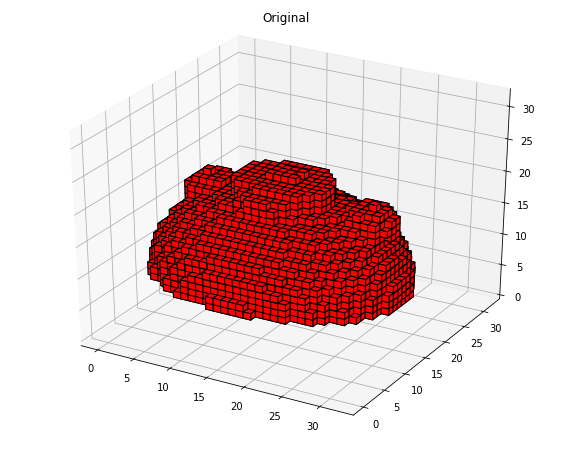

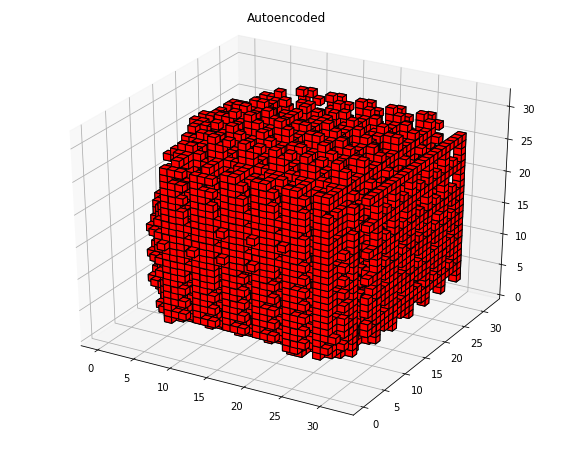

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-69.ckpt
Epoch: 70, Batch: 0
Epoch: 70, Batch: 1
Epoch: 70, Batch: 2
Epoch: 70, Batch: 3
Epoch: 71, Batch: 0
Epoch: 71, Batch: 1
Epoch: 71, Batch: 2
Epoch: 71, Batch: 3
Epoch: 72, Batch: 0
Epoch: 72, Batch: 1
Epoch: 72, Batch: 2
Epoch: 72, Batch: 3
Epoch: 73, Batch: 0
Epoch: 73, Batch: 1
Epoch: 73, Batch: 2
Epoch: 73, Batch: 3
Epoch: 74, Batch: 0
Epoch: 74, Batch: 1
Epoch: 74, Batch: 2
Epoch: 74, Batch: 3
Epoch: 0075 Loss = 9302.194335938 Elapsed time: 65.73547408183416 mins
Generation Example:


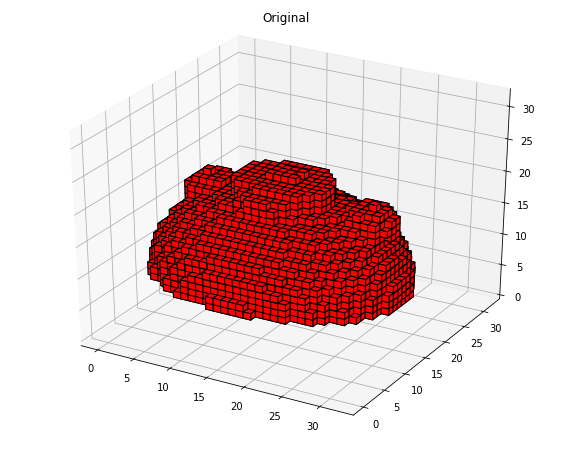

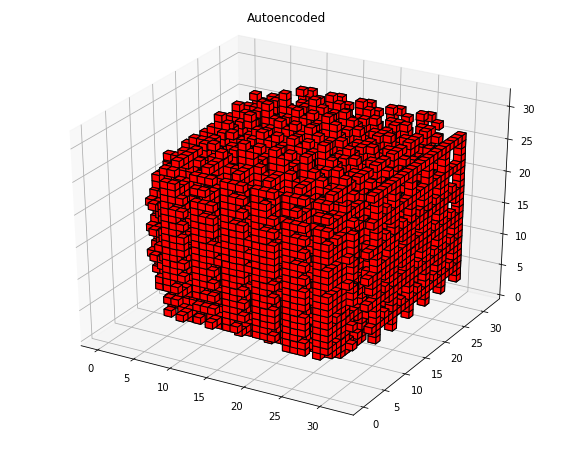

Epoch: 75, Batch: 0
Epoch: 75, Batch: 1
Epoch: 75, Batch: 2
Epoch: 75, Batch: 3
Epoch: 76, Batch: 0
Epoch: 76, Batch: 1
Epoch: 76, Batch: 2
Epoch: 76, Batch: 3
Epoch: 77, Batch: 0
Epoch: 77, Batch: 1
Epoch: 77, Batch: 2
Epoch: 77, Batch: 3
Epoch: 78, Batch: 0
Epoch: 78, Batch: 1
Epoch: 78, Batch: 2
Epoch: 78, Batch: 3
Epoch: 79, Batch: 0
Epoch: 79, Batch: 1
Epoch: 79, Batch: 2
Epoch: 79, Batch: 3
Epoch: 0080 Loss = 9053.227539062 Elapsed time: 70.14423910379409 mins
Generation Example:


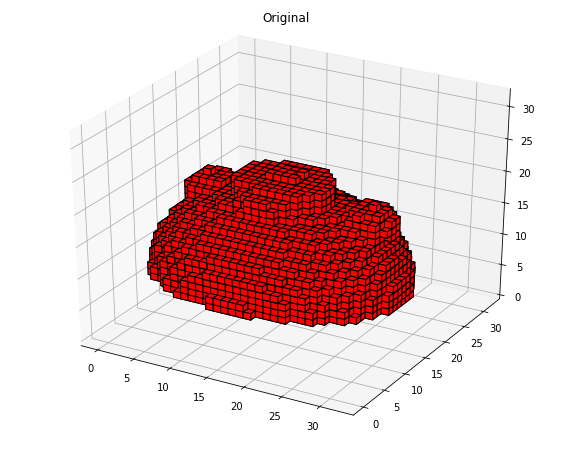

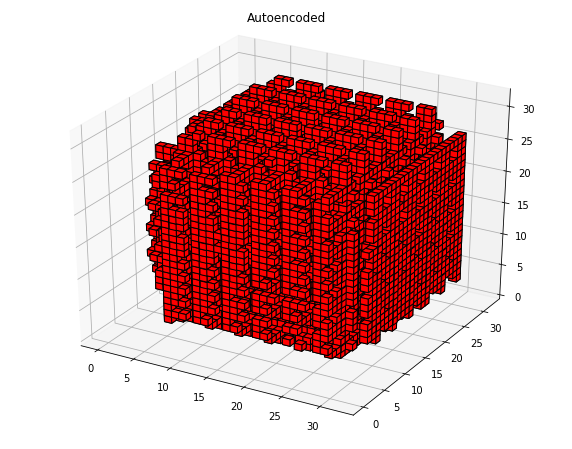

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-79.ckpt
Epoch: 80, Batch: 0
Epoch: 80, Batch: 1
Epoch: 80, Batch: 2
Epoch: 80, Batch: 3
Epoch: 81, Batch: 0
Epoch: 81, Batch: 1
Epoch: 81, Batch: 2
Epoch: 81, Batch: 3
Epoch: 82, Batch: 0
Epoch: 82, Batch: 1
Epoch: 82, Batch: 2
Epoch: 82, Batch: 3
Epoch: 83, Batch: 0
Epoch: 83, Batch: 1
Epoch: 83, Batch: 2
Epoch: 83, Batch: 3
Epoch: 84, Batch: 0
Epoch: 84, Batch: 1
Epoch: 84, Batch: 2
Epoch: 84, Batch: 3
Epoch: 0085 Loss = 9278.246093750 Elapsed time: 74.57871988217036 mins
Generation Example:


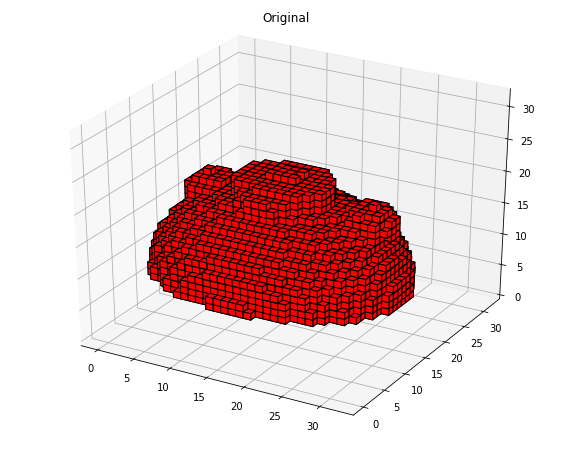

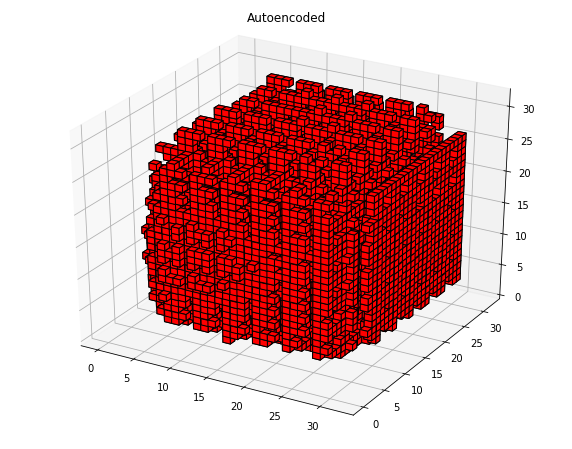

Epoch: 85, Batch: 0
Epoch: 85, Batch: 1
Epoch: 85, Batch: 2
Epoch: 85, Batch: 3
Epoch: 86, Batch: 0
Epoch: 86, Batch: 1
Epoch: 86, Batch: 2
Epoch: 86, Batch: 3
Epoch: 87, Batch: 0
Epoch: 87, Batch: 1
Epoch: 87, Batch: 2
Epoch: 87, Batch: 3
Epoch: 88, Batch: 0
Epoch: 88, Batch: 1
Epoch: 88, Batch: 2
Epoch: 88, Batch: 3
Epoch: 89, Batch: 0
Epoch: 89, Batch: 1
Epoch: 89, Batch: 2
Epoch: 89, Batch: 3
Epoch: 0090 Loss = 8521.979492188 Elapsed time: 79.00165668328603 mins
Generation Example:


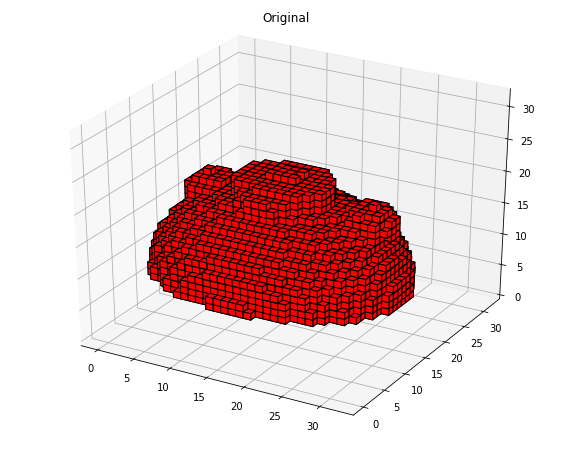

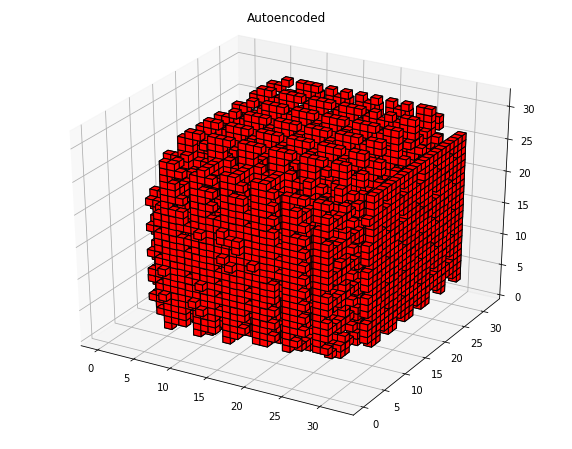

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-89.ckpt
Epoch: 90, Batch: 0
Epoch: 90, Batch: 1
Epoch: 90, Batch: 2
Epoch: 90, Batch: 3
Epoch: 91, Batch: 0
Epoch: 91, Batch: 1
Epoch: 91, Batch: 2
Epoch: 91, Batch: 3
Epoch: 92, Batch: 0
Epoch: 92, Batch: 1
Epoch: 92, Batch: 2
Epoch: 92, Batch: 3
Epoch: 93, Batch: 0
Epoch: 93, Batch: 1
Epoch: 93, Batch: 2
Epoch: 93, Batch: 3
Epoch: 94, Batch: 0
Epoch: 94, Batch: 1
Epoch: 94, Batch: 2
Epoch: 94, Batch: 3
Epoch: 0095 Loss = 7515.660156250 Elapsed time: 83.42542662620545 mins
Generation Example:


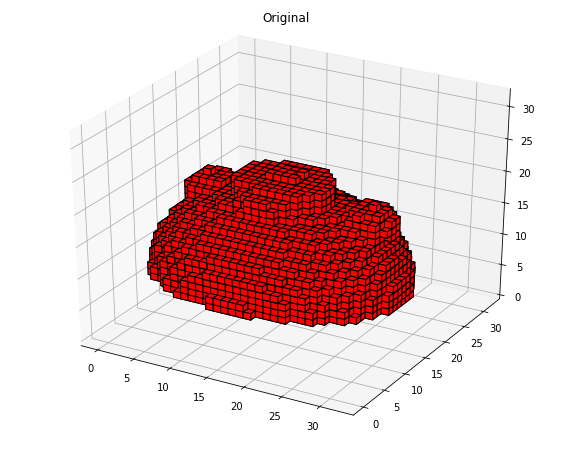

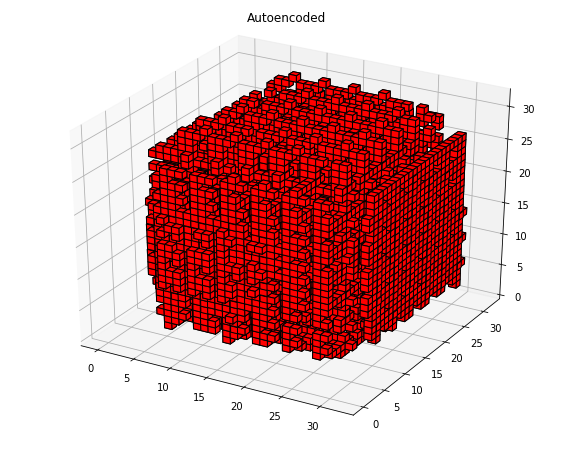

Epoch: 95, Batch: 0
Epoch: 95, Batch: 1
Epoch: 95, Batch: 2
Epoch: 95, Batch: 3
Epoch: 96, Batch: 0
Epoch: 96, Batch: 1
Epoch: 96, Batch: 2
Epoch: 96, Batch: 3
Epoch: 97, Batch: 0
Epoch: 97, Batch: 1
Epoch: 97, Batch: 2
Epoch: 97, Batch: 3
Epoch: 98, Batch: 0
Epoch: 98, Batch: 1
Epoch: 98, Batch: 2
Epoch: 98, Batch: 3
Epoch: 99, Batch: 0
Epoch: 99, Batch: 1
Epoch: 99, Batch: 2
Epoch: 99, Batch: 3
Epoch: 0100 Loss = 7147.202636719 Elapsed time: 87.84844615856807 mins
Generation Example:


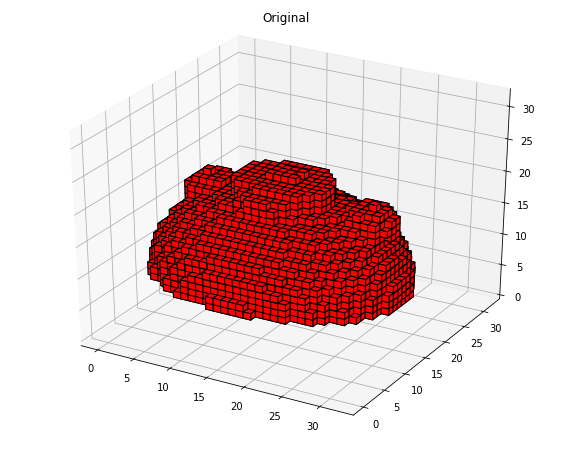

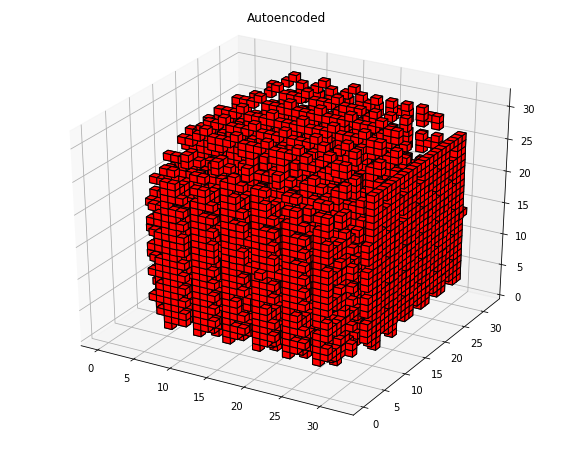

Model saved in path: /home/jcworkma/jack/3d-form/src/../models/voxel_vae/model_epoch-99.ckpt


In [4]:
tf.reset_default_graph()
VOXELS_DIM = 32
BATCH_SIZE = 30

try:
    vae = VariationalAutoencoder(input_dim=VOXELS_DIM,
                                 latent_dim=200,
                                 learning_rate=0.0001,
                                 keep_prob=0.8,
                                 verbose=False)

    generator = lambda: thingi.voxels_batchmaker(batch_size=BATCH_SIZE, voxels_dim=VOXELS_DIM, verbose=False)

    vae.train(generator, epochs=100, display_step=5, save_step=10)
except Exception as exc:
    vae.close()
    raise(exc)

In [5]:
for i, recon in enumerate(vae.recons):
    print('--------------')
    print(i)
    print(recon.max())
    print(recon.min())


--------------
0
True
False
--------------
1
True
False
--------------
2
True
False
--------------
3
True
False
--------------
4
True
False
--------------
5
True
False
--------------
6
True
False
--------------
7
True
False
--------------
8
True
False
--------------
9
True
False
--------------
10
True
False
--------------
11
True
False
--------------
12
True
False
--------------
13
True
False
--------------
14
True
False
--------------
15
True
False
--------------
16
True
False
--------------
17
True
False
--------------
18
True
False
--------------
19
True
False


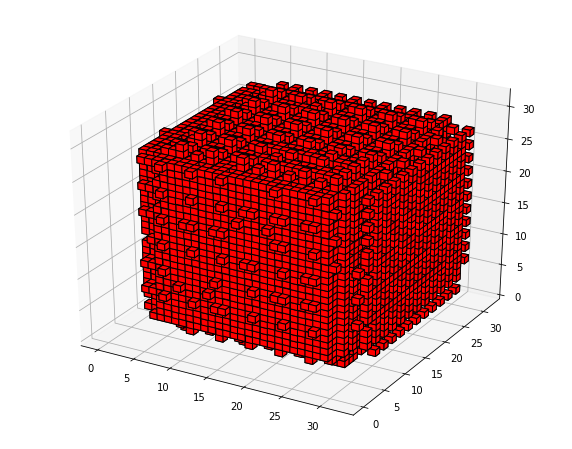

In [6]:
plot_voxels(np.around(vae.recons[1]))

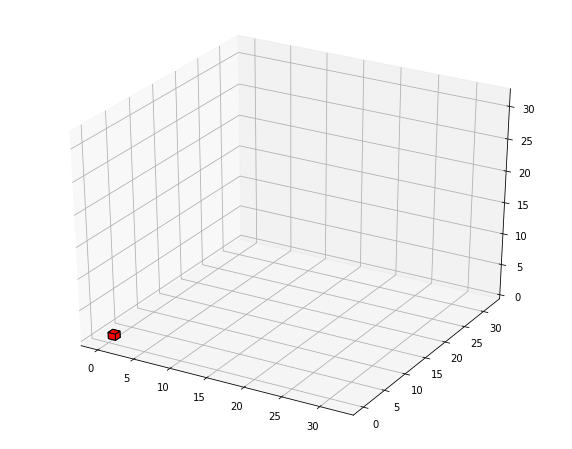

In [7]:
# what does a voxel array of nans look like when plotted?
x = np.zeros((32, 32, 32))
#x.fill(np.nan)
x[0][0][0] = 1
plot_voxels(x)


In [8]:
from data.voxels import read_voxel_array
path = '/home/jcworkma/jack/3d-form/src/../data/processed/Thingi10k/voxels/32/1131717.binvox'
read_voxel_array(path).dims

[32, 32, 32]

In [9]:
x = np.fromtxt('/home/jcworkma/jack/3d-form/src/../models/voxel_vae/recon_epoch-0.npy')
print(x.max())

AttributeError: module 'numpy' has no attribute 'fromtxt'